In [2]:
import src
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings
# Pandas will give a lot of warning while I am mutating data frames in functions.
filterwarnings('ignore')
# Matplot lib inline
plt.style.use('seaborn')
sns.set_style("whitegrid")
%matplotlib inline

# Initial Questions Relating to Budget and ROI
We were interested in whether there is a diminishing return on investment for movie budgets. Is there a goldilocks zone for movie budgets where Microsoft should focus their efforts? Lets dive into the cleaned budget dataframe and check it out!

In [194]:
df = pd.read_csv("rawdata/clean_roi_budget_data")
df.head()

FileNotFoundError: [Errno 2] File b'rawdata/clean_roi_budget_data' does not exist: b'rawdata/clean_roi_budget_data'

# Early Exploration
The first plot we will look at is a simple scatter plot with budget on the x axis and ROI on the y axis. We used budget category as our 'hue' to visually illustrate the difference between the different budget categories. Budget categories were added as part of the data cleaning process. The small budget category is movies that cost less than 5 million usd to make, the medium category is movies that cost between 5 million usd and 100 million and the large budget category is movies that cost over 100 million. These categories were roughly based on [industry](https://stephenfollows.com/average-budget-low-micro-budget-film/)  [standards](https://industrialscripts.com/great-mid-budget-movies/), althouth there is no exact number for what makes a movie "small budget."

NameError: name 'df' is not defined

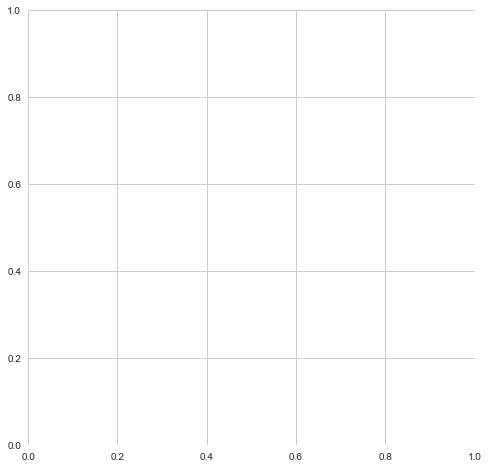

In [49]:
fig2, axes = plt.subplots( figsize = (8,8))
ax = sns.scatterplot(x = 'production_budget', y = 'roi',hue = 'budget_category', data = df)
ax.set(ylim = (-100,5000))
ax.set_title('Production Budget vs. ROI')
ax.set_ylabel('ROI')
ax.set_xlabel('Production Budget')
plt.savefig( 'Production Budget vs. ROI.png')

Wow! if anything budget size seems to have a negative correlation with ROI. However there are also massive outliers in the small category with ROIs over 1000%. Lets Plot the data without these small budget movies that garnered absurd ROIs and see what the data looks like.

In [ ]:
df2 = df[df.roi<1000]
fig2, axes = plt.subplots( figsize = (16, 8))
ax = sns.scatterplot(x = 'production_budget', y = 'roi',hue = 'budget_category', data = df2)
ax.set(ylim = (-100,1100))
ax.set_title('Production Budget vs. ROI (without outliers)', size = 15)
ax.set_ylabel('ROI')
ax.set_xlabel('Production Budget')
plt.savefig( 'Production Budget vs. ROI.png')

Ok now it still looks like small and medium budget movies produce a higher but more variable roi, while the majoiry of high budget movies are clustered in a similar place to small and medium budget movies. Its also interesting that large budget movies seem to have less points with a negative ROI. **This led us to a further question: which budget category carries the most risk?**

# Average ROI

The following bar graphs look at the average roi for each budget category. 

In [ ]:

fig, axes = plt.subplots(1, 2, figsize = (16,8), sharey = True)
sns.barplot(y= df['roi'], x = df['budget_category'], ax = axes[0]);
axes[0].set_title('Mean ROI categorized by budget without outliers', size = 15)
axes[0].set_ylabel('ROI')
axes[0].set_xlabel('Budget Category');
axes[1] = sns.barplot(y= df[df['roi']<1000]['roi'], x = df['budget_category'], ax = axes[1]);
plt.title('Mean ROI categorized by budget without outliers', size = 15)
plt.ylabel('ROI')
plt.xlabel('Budget Category');

With the outliers, small moves crush average ROI. Interestingly large and medium budget movies do about the same. With or without the outliers, but small movies do much worse. Unless your small movie is an absolute run away success you can do the best by focusing on large budget movies.

In [ ]:
y =df['domestic_roi']
sns.barplot(y= y, x = df[df.roi<1000]['budget_category']);
plt.title('Average Domestic ROI for Movies Categorize by Budget', size = 15)
plt.xlabel('Domestic ROI')
plt.ylabel('Budget Category');

With just domestic ROI no budget category is even close to the ROI it garners from worldwide distribution. We strongly recommend that Microsoft distribute their content globally, almost as a neccesity.

In [ ]:
#Calculating the percent chance that a project lost money for each category

p_lost_money_small = len(df[(df.budget_category == 'small') & (df.lost_money == True)])/len(df[df.budget_category =='small']) * 100

p_lost_money_medium = len(df[(df.budget_category == 'medium') & (df.lost_money == True)])/len(df[df.budget_category =='medium']) * 100

p_lost_money_large = len(df[(df.budget_category == 'large') & (df.lost_money == True)])/len(df[df.budget_category =='large']) * 100

x = ['Small Budget', 'Medium Budget', 'Large Budget']
y = [p_lost_money_small, p_lost_money_medium, p_lost_money_large]

In [ ]:
ax = sns.barplot(y, x);
ax.set_title('Percentage of movies that lost money in each budget category', size = 15)
plt.xlabel('Percent of movies that lost money')
plt.ylabel('Production Budget');

Its clear that as budget increases, the risk of losing money on your project goes down. That being said the more expensive a project the more money its possible to lose. Small budget may have the possibility of massive ROI, but they are also clearly the most risky.

# Conclusion on Budget ROI section

We Recommend that Microsoft use most of their money on large budget movies which offer less risk and a predictable ROI. Medium budget movies are high risk and do not have much upside, they should be avoided. Small budget movies offer the possibility of ROIs over 1000% but are extremely risky. Small budget movies should not be the foundation of Microsofts content but they also shouldnt shy away from them in the hope that one goes 'viral.' Next we will look ahead at what genre Microsoft should focus on for their large productions, and if certain small budget movies have a higher chance of producing massive ROIs.

## Genre Analysis
Our hypothesis was that genre played a large role in the ratings and success of a movie. To test this we created a custom function to examine the average return on investment (roi) and total international gross revenue.

In [10]:
# import the cleaned data as described in /datacleaning/genrecleaning.ipynb
df1  = pd.read_csv('rawdata/genres-budget.csv')
df2 = pd.read_csv('rawdata/genre-month-roi.csv')
df_titles = pd.read_csv('rawdata/title.csv')

### Explanation of the table
We wrangled this data from data sets scraped from imdb and  includes a truth matrix for all the genres to allow simple indexing as well as metadata pertaining the movies overall success.

We removed all observations with missing values for genre, worldwide_gross and production_budget as these values are critical to our hyptotheses. In addition, no observations from before 2010 and after 2019 were included in the data set. This was to insure the relevance of the data to the business question at hand.

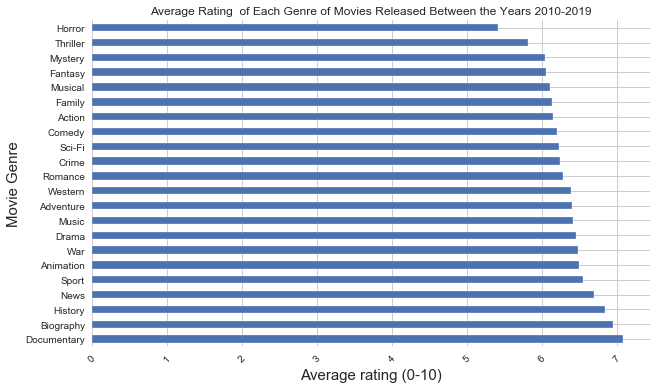

In [12]:
# src function and documentation available in src.py
df1.genres = src.coerce_to_list(df1, 'genres')
df_to_plot = src.genre_pandas_mean(df1, 'averagerating')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Average Rating  of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('Average rating (0-10)', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

#### Genre doesn't have a large impact on rating

This is no surprising, movies from any genre can perform well. So we asked how well do movies perform as a function of their production budget.

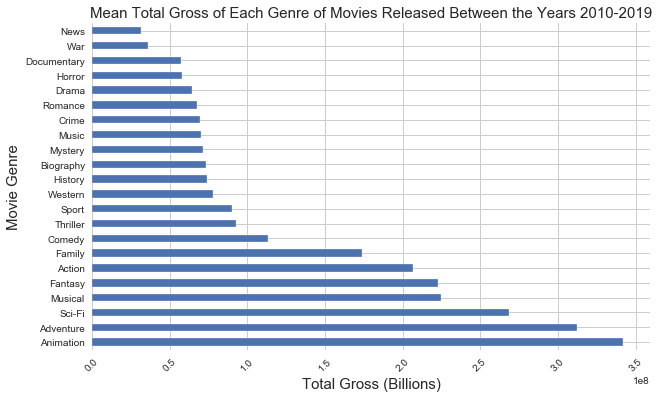

In [13]:
df_to_plot = src.genre_pandas_mean(df1, 'worldwide_gross')
df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean Total Gross of Each Genre of Movies Released Between the Years 2010-2019', size=15)
plt.xlabel('Total Gross (Billions)', size = 15)
plt.ylabel('Movie Genre', size = 15);
plt.savefig('roi_genre.png')

#### Animation, Adventure, Sci-Fi have dominated over the past 10 years

Big production budgets on superhero movies have skewed this data. It would be interesting to look into the performance of superhero movies and franchises. Future research should look into that relationship.

However, total gross income from a movie isn't the fairest indicator of success. When we normalize the data by production budget to get the return on investment, a different story emerges.

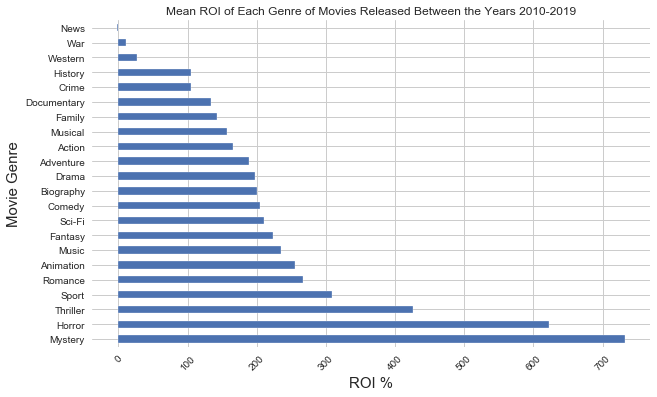

In [14]:
# See src.genre_pandas_mean in src documentation
df_to_plot = src.genre_pandas_mean(df1, 'roi')

df_to_plot.plot(kind='barh', legend=False,figsize=(10,6))


plt.xticks(rotation = 45)
plt.title('Mean ROI of Each Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15)
plt.savefig('roi_genre.png');

#### So people seem to have a morbid curiousity
When we look at the ROI, the top genres are now replaced by Mystery, Horror and Thrillers. Almost 40% of movies made contain one of these horror tags. So, not only are they good value for money but they seem to be relatively simply to make. Further research should be done on the production costs, both financial and time of producing these movies.


However, this analysis includes duplicate values in the means. So this begs the question, is there some magical combination of genres that leads to high return on investment?

In [15]:
thriller = len(df1[df1.Thriller==True])/len(df1)
horror = len(df1[df1.Horror==True])/len(df1)
mystery = len(df1[df1.Mystery==True])/len(df1)

print((thriller+horror+mystery)* 100)

38.301636444051304


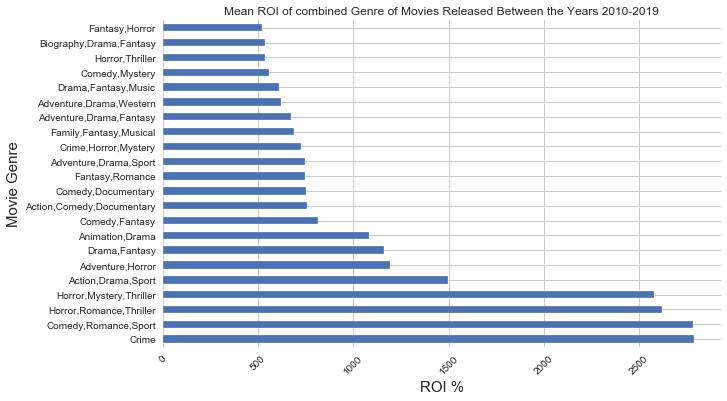

In [16]:
# Reload the database to reset the genre column from list back to string
df1 = pd.read_csv('rawdata/genres-budget.csv')

# Group the values by genre (combinations present this time) and check ROI for the top 22 genres
grouped = df1.groupby(['genres']).roi.mean().sort_values(ascending=False)[:22]

# Create chart based on the data
# See src.genre_pandas_mean in src documentation
grouped.plot(kind='barh', legend=False,figsize=(10,6))
plt.xticks(rotation = 45)
plt.title('Mean ROI of combined Genre of Movies Released Between the Years 2010-2019')
plt.xlabel('ROI %', size = 15)
plt.ylabel('Movie Genre', size = 15)
plt.savefig('roi_genre.png');

#### So as it happens, crime does pay!

Or atleast people are willing to spend a signeficant amount of money to watch it. 

And as we expected, Horror, Mystery and Thriller are all featured in top 5. But interestingly, they do not take the top spot over all.

As discussed in the previous section, there are a large number of outliers in our data set. Considering the relatively small sample size, a single large value can offset our data.

In [33]:
# Find the top Crime movie by ROI
df1[df1.Crime == True].sort_values('roi', ascending=False).roi.values[0]
title=df1[df1.Crime == True].sort_values('roi', ascending=False).tconst.values[0]
df_titles[df_titles.tconst == title].primary_title.values[0]

'split'

Split is more of a mystery/crime/thriller if you ask us. Which brings me to a key point about this analysis, The categorization by genre is subjective and therefore taken alone is not firm evidence for the success of one genre over another. 

The trend is that horror movies, thrillers and crime movies generate a great return on investment. But, does is matter how much money you invest initially? It there a point of dimninishing returns for your investment?

Using the same categorization method from our first section we used a categorization plot to directly compare budget categoy and ROI. I produced this dataframe in the `datacleaning` note book. We chose to include duplicates for each genre. Though this amplifies the effect of outliers, It also let's us examine indiviual genre performance.

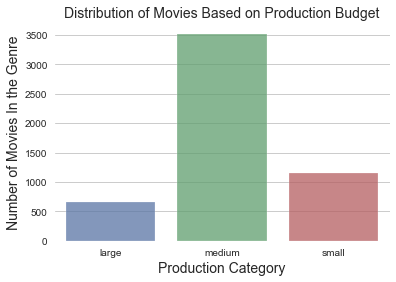

In [43]:
# Look at our category counts
category_counts = df2.groupby(['production_category']).tconst.count()
sns.barplot(y=category_counts , x = category_counts.index, alpha=0.75)
plt.ylabel("Number of Movies In the Genre", size = 14)
plt.xlabel("Production Category", size = 14)
plt.title("Distribution of Movies Based on Production Budget", size = 14);

We do not have balance in our dataset. However, the categorization using 5 million - 100 million being medium or normal is the industry standard according to Variety magazine. 

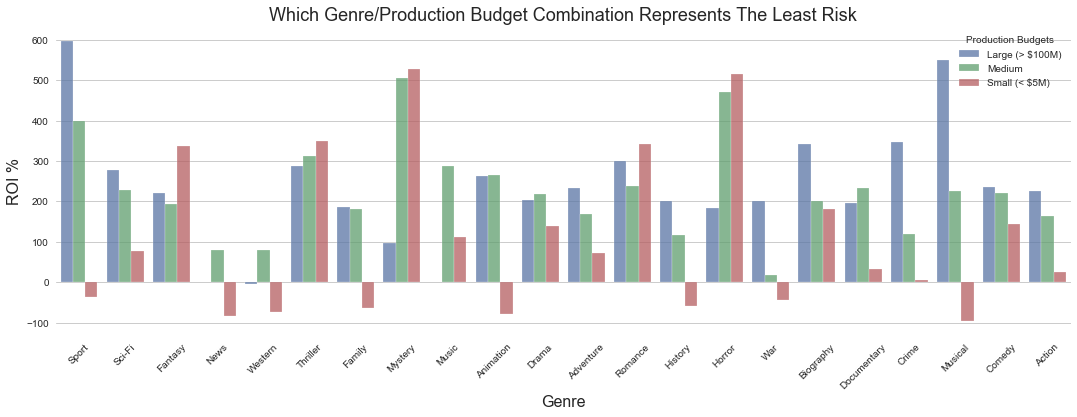

In [46]:
# Categorical plot examining the effect of genre on ROI
sns.catplot(x = 'genre',
            y = 'roi',
            hue = 'production_category', 
            data = df2,
            kind = 'bar',
            height = 5,
            aspect =3, 
            alpha=0.75, 
            legend=False, ci=None
            );
plt.xticks(rotation = 45)
plt.title("Which Genre/Production Budget Combination Represents The Least Risk", size = 18);
plt.legend(title = 'Production Budgets', loc=1, labels= ['Large (> $100M)', 'Medium', 'Small (< $5M)'])
plt.ylabel("ROI %", size = 16);
plt.xlabel("Genre", size=16 )
plt.savefig('images/genre-roi-budget.png', bbox_inches = "tight");

The relative size of each group makes it difficult to interpret the data. However, it is clear that depending on genre of movie, budget considerations are very important. For example, musicals perform very well when the budget is hight, but if the budget is too low, you run the risk of losing a lot of money. 

#### Conclusion from Genre Analysis

Despite the low numbers in our data, we reccomend high budget (>100M) Sport movies and Musicals, medium budget (between 5M and 100M) mysteries, and low budget (< 5M) Horror movies.

Further supplementary data is necessary to evaluate the extent of this pattern. 

## Time Series: When to Release?

Up until this point we have looked exlusively at static features. Here, we attempt to interpret the value of releasing at certain times. 

The for this, we first looked into both the number of releases per month and the sentiment value of each review for that movie. 

The mean sentiment score was determined using the `Vader Sentiment` module that can be found here:
https://github.com/cjhutto/vaderSentiment

In [174]:
# Lets bring some more data sets 
df_budgets = pd.read_csv('./rawdata/tn.movie_budgets.csv')
df_rotten = pd.read_csv('./rawdata/rotten-sentiments.csv')
df_tmdb = pd.read_csv('./zippedData/tn.movie_budgets.csv.gz', index_col=0)

In order to get the larges amount of data possible, I will create a months column in each data set, groupby the month column and count the individual items. Then I can add those together since they are of equal length to get the total relases per month. The disadvantage of this method is you loose the measure of dispersion but when you just want raw numbers this is an effective method.

In [175]:
# in order to see how many movies were released on a given day, we have to create a subset of the data with 1 entry per movie
df_no_dup_series = df_rotten.id.drop_duplicates()
df_rotten = df_rotten.iloc[df_no_dup_series.index]
df_rotten.shape


# Clean rotten data up for merging on a month_day column
df_rotten = df_rotten[df_rotten['theater_date'].notnull()]

# convert to datetime object
df_rotten.theater_date = pd.to_datetime(df_rotten.theater_date)


df_rotten['month'] = df_rotten.theater_date.dt.strftime("%m") 
df_rotten['day'] = df_rotten.theater_date.dt.strftime('%d')
df_rotten['year'] = df_rotten.theater_date.dt.strftime('%Y').astype(int)
df_rotten['month_day'] =  df_rotten.theater_date.dt.strftime('%m%d')

# Exclude all observations from before 2010
df_rotten = df_rotten[(df_rotten.year > 2009)]
rotten_grouped = df_rotten.groupby(['month']).id.count()

In [177]:
# Create the appropriate time columns in tmdb budget for merging
df_tmdb.release_date = pd.to_datetime(df_tmdb.release_date)
df_tmdb['month_day'] = df_tmdb.release_date.dt.strftime("%m%d")
df_tmdb['month'] = df_tmdb.release_date.dt.strftime("%m").astype(int)
df_tmdb['year'] = df_tmdb.release_date.dt.strftime("%Y").astype(int)
# Filter by year
df_tmdb = df_tmdb[df_tmdb.year > 2009]
tmdb_grouped = df_tmdb.groupby(['month']).movie.count()

In [189]:
# Do the same operation for df_budge
df_budgets.release_date = pd.to_datetime(df_budgets.release_date)
df_budgets['month_day'] = df_budgets.release_date.dt.strftime("%m%d")
df_budgets['month'] = df_budgets.release_date.dt.strftime("%m")
df_budgets['year'] = df_budgets.release_date.dt.strftime("%Y").astype(int)
df_budgets = df_budgets[df_budgets.year > 2009]
budgets_grouped = df_budgets.groupby(['month']).id.count()


In [190]:
# Concatenate the three total movies in a given month
total_monthly = tmdb_grouped.values + budgets_grouped.values + rotten_grouped.values
total_monthly = pd.Series(total_monthly)
total_monthly

0     300
1     340
2     411
3     381
4     322
5     337
6     332
7     369
8     392
9     418
10    366
11    580
dtype: int64

Now that we have a a series with the month position as the index and the values ofa number of movies, we can graph the results. But first a few quick manipulations

In [180]:
# Pull out the median Sentiment per month
sentiment_grouped = df_rotten.groupby(['month']).sentiment.median()

In [181]:
# Convert the series back into a dataframe
df_sentiment =sentiment_grouped.reset_index()
# Convert the month to an int
df_sentiment.month =df_sentiment.month.astype(int)

df_monthly_numbers = total_monthly.reset_index()
df_monthly_numbers.columns = ['Month', 'Number of Movies']

In [182]:
df_monthly_numbers

,Month,Number of Movies
0,0,300
1,1,340
2,2,411
3,3,381
4,4,322
5,5,337
6,6,332
7,7,369
8,8,392
9,9,418


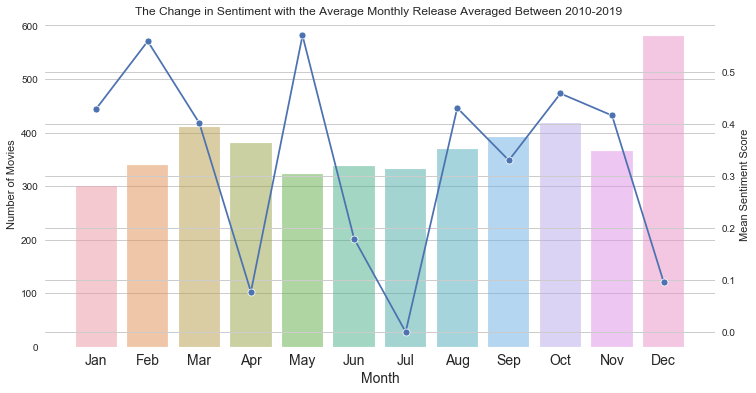

In [193]:
# Plot monthly release and sentiment value on the same plot\
# Convert monthly_series back to dataframe

# ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.set_xlabel(f'Month', size = 12)

sns.barplot(data = df_monthly_numbers, x='Month', y='Number of Movies', alpha=0.5, ax=ax1)
ax2 = ax1.twinx()
ax2.set_ylabel('Mean Sentiment Score')
ax1.set_xticklabels(['Jan',
                     'Feb',
                     'Mar',
                     'Apr',
                     "May", 
                     "Jun", 
                     "Jul", 
                     "Aug",
                     "Sep", 
                     "Oct", 
                     "Nov", 
                     "Dec"],
      size = 14)
ax1.set_title("The Change in Sentiment with the Average Monthly Release Averaged Between 2010-2019 ")
ax1.set_xlabel("Month", size=14)

sns.lineplot(data = df_sentiment['sentiment'], marker='o', sort = False, ax=ax2);

It seems that sentiment decreases signeficantly as the timeperature p

In [163]:
# Import cleaned data frame for the final graph. Cleaning and production is in `datacleaning`
df = pd.read_csv('./rawdata/genre-month-roi.csv')

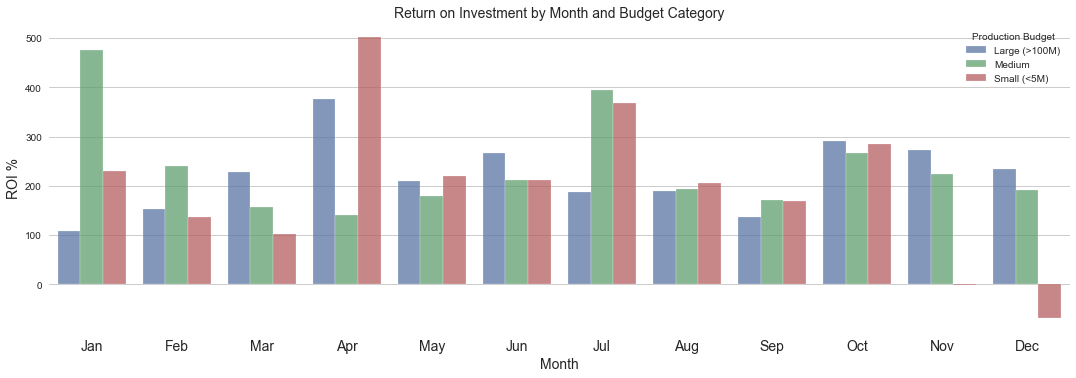

In [186]:
sns.catplot(x = 'month',
            y = 'roi', 
            hue = 'production_category',
            data = df, 
            kind = 'bar',
            height = 5, 
            aspect =3, 
            ci=None, 
            legend=False, 
            alpha = 0.75)
plt.xticks(ticks= list(range(0,12)), labels=['Jan',
                                             'Feb',
                                             'Mar',
                                             'Apr',
                                             "May", 
                                             "Jun", 
                                             "Jul", 
                                             "Aug",
                                             "Sep", 
                                             "Oct", 
                                             "Nov", 
                                             "Dec"],
          size = 14)
plt.title("Return on Investment by Month and Budget Category", size = 14);
plt.xlabel("Month", size = 14)
plt.ylabel("ROI %", size =14)
plt.legend(title = "Production Budget", labels = ["Large (>100M)", "Medium", 'Small (<5M)']);
plt.savefig('images/month-roi-budget.png', bbox_inches = "tight");


So it seems that there is a relationship between the budget size of movies and the release date. This adds a temporal element to our findings. January appears to to have a strong preference for normal budget movies whereas December, low budget movies perform terribly overall. 

## Conclusion

It is our opinion that if Microsoft wishes to get into the movie industry, the safest way to do so would be to invest heavily into large, blockbuster type films particularly Musicals and Sports based movies to do well. In addition, they should aim to release those movies in either April, October or December to have the greatest expected ROI.

However, smaller budget films have almost a 15% chance of returning over 1000%. This is something that should be investigated further. In particular, Horror, Crime and Mystery films can yeild an enormous ROI under some currently undiscovered conditions. It is our opinion that any studio should be investing in lower budget indie films in order to maximise their chances of returning on their investment. 
